In this notebook I will extract the density of the functional group that might be in the active layer.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
#from uncertainties import unumpy

import inverse_method_funs as inv
import sb_tools

%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

# Read scattering models
Import species backscattering cross section matrix

In [3]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'

specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

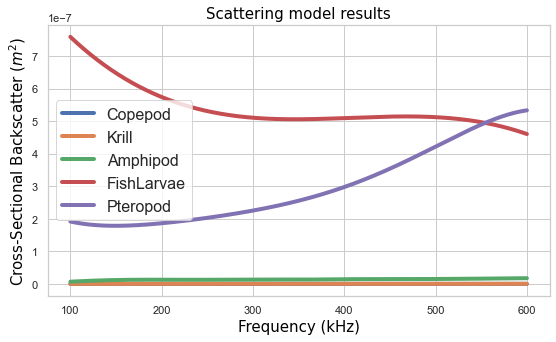

In [4]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Resample to line up output and input

In [5]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')

sv_all = np.zeros((1001,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))

In [6]:
len(freqs_EV)

1001

In [7]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])
ci_boot0 = np.zeros([len(freqs_EV),len(specs)])
ci_boot1 = np.zeros([len(freqs_EV),len(specs)])


for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])
    ci_boot0[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[0,:,ind_spec])
    ci_boot1[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[1,:,ind_spec])

In [8]:
np.shape(sigbs_mean)

(1001, 5)

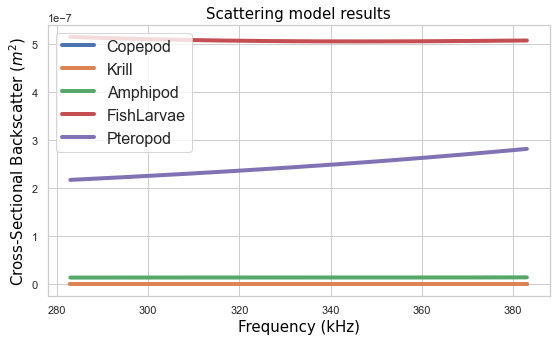

In [9]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigbs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

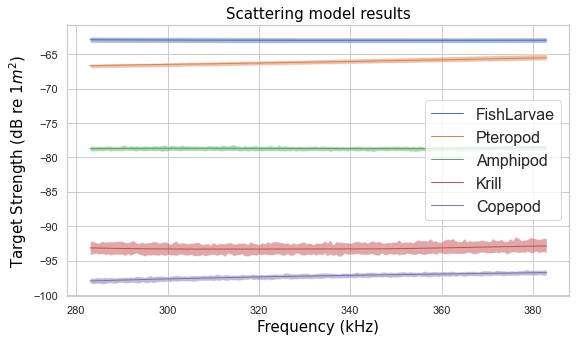

In [10]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in [3,4,2,1,0]:
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(sigbs_mean[:,ind]) - (10*(0.434*(sigbs_mean[:,ind]-ci_boot0[:,ind])/sigbs_mean[:,ind]))
    logci_1 = 10*np.log10(sigbs_mean[:,ind]) + 10*(0.434*(ci_boot1[:,ind]-sigbs_mean[:,ind])/sigbs_mean[:,ind])
    
    plt.plot(freqs_EV[:],10*np.log10(sigbs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],logci_0,logci_1, alpha=0.5)
    
plt.legend(fontsize=16)
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Inverse method
Calculate mean predicted density for each active layer

# Read wideband frequency response
Read the Echoview export of wideband frequency response. sv pulse compressed.

- For each file export 1 estimate with error bars. (August 18th)

In [11]:
fname_EV;

And Run a least squares solver

In [12]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*_ssl.csv')
nfiles = len(fname_EV)

sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))
density = np.zeros((5, nfiles))
density_mean = np.zeros((5, nfiles))
density_std0 = np.zeros((nfiles,5))
density_std1 = np.zeros((nfiles,5))
sigbs = sigbs_mean
for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
    sv_mean = np.mean(sv_out,1)
    sv_std = np.mean(sv_out,1)
    
    density_out = np.zeros([np.shape(sigbs_mean)[1], np.shape(sv_out)[1]])
    for sv_ind in np.arange(np.shape(sv_out)[1]):
        d = optimize.lsq_linear(sigbs, sv_out[:,sv_ind], bounds=(0,np.inf))
        density_out[:,sv_ind] =  d.x

    sv_all = np.append(sv_all, sv_out, axis=1)
    times = np.append(times, times_out[0])
    density_mean[:,ind] = np.mean(density_out,1)
    
    d = optimize.lsq_linear(sigbs, sv_mean, bounds=(0,np.inf))
    density[:,ind] =  d.x
    #for spec_ind in np.arange(len(specs)):

        # try with unumpy
        #sv_u = unumpy.umatrix(sv_mean,sv_std)
        #sig_u = unumpy.umatrix(sigbs,ci_boot0)
        #sig_u1 = unumpy.umatrix(sigbs,ci_boot1)
        #density_mean_u = unumpy.nominal_values(sv_u*sig_u)
        #density_mean_u1 = unumpy.nominal_values(sv_u*sig_u1)
        #density_std_u = unumpy.std_devs(sv_u*sig_u)
        #density_std_u1 = unumpy.std_devs(sv_u*sig_u1)
        #density_std0[ind,spec_ind] = (sv_u*sig_u)
        #density_std1[ind,spec_ind] = (sv_u*sig_u1)

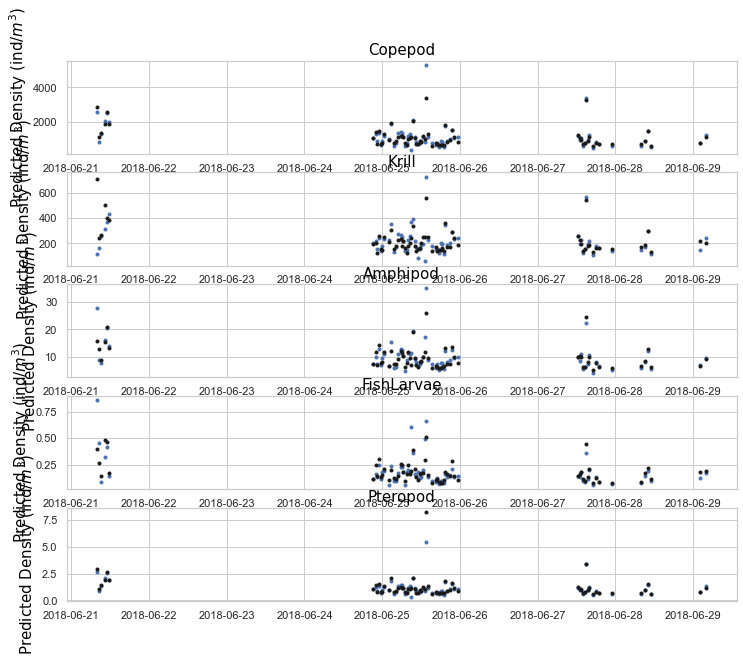

In [13]:
plt.figure(figsize=(12, 12),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(len(specs)+1,1,ind+1)
    plt.plot(times, density[ind,:], '.')
    plt.plot(times, density_mean[ind,:], '.k')
    plt.title(specs[ind], title_font)
    plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)

## Load lat/lon

In [14]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [15]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [16]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [17]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(len(times)):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'Acoustics'}, 
                            'ignore_index=True')

## Add net data

In [19]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [20]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,17):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

In [21]:
## Add log of data as column
data['log_density']=np.log10(data.density+1)
data['log_density'][np.isnan(data['log_density'])]==0


Series([], Name: log_density, dtype: bool)

<AxesSubplot:xlabel='source', ylabel='density'>

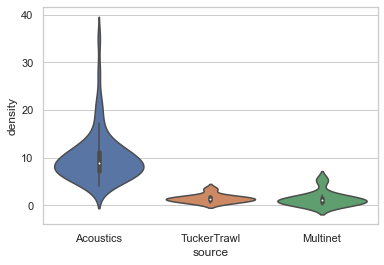

In [22]:
sns.violinplot(data=data[data.species=='Amphipod'], x='source', y='density', scale='width')

<AxesSubplot:xlabel='source', ylabel='density'>

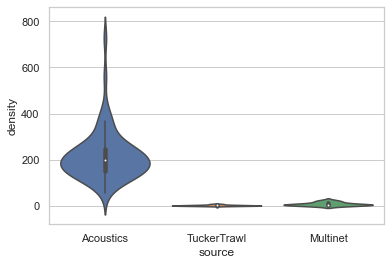

In [23]:
sns.violinplot(data=data[data.species=='Krill'], x='source', y='density', scale='width')

<AxesSubplot:xlabel='source', ylabel='density'>

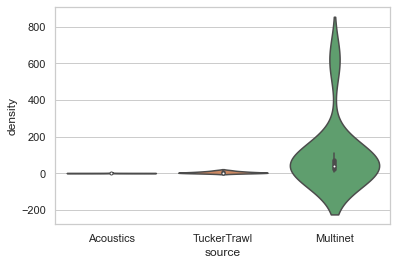

In [24]:
sns.violinplot(data=data[data.species=='Pteropod'], x='source', y='density', scale='width')

<AxesSubplot:xlabel='source', ylabel='density'>

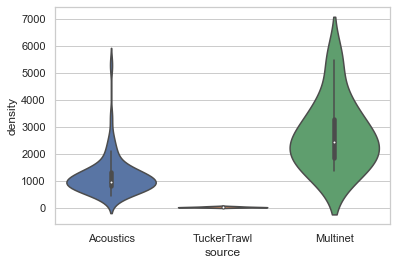

In [25]:
sns.violinplot(data=data[data.species=='Copepod'], x='source', y='density', scale='width')

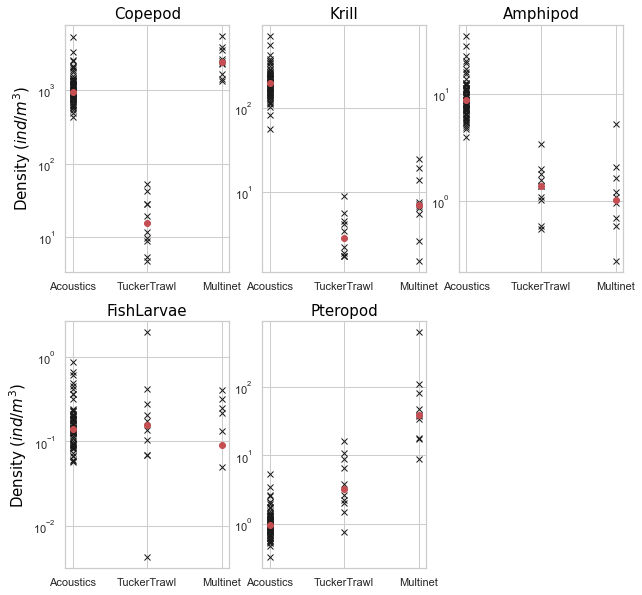

In [26]:
fig = plt.figure(figsize=(10,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    ax.semilogy(data.source[data.species==specs[ind_spec]],data.density[data.species==specs[ind_spec]], 'kx')
    ax.semilogy(data[data.species==specs[ind_spec]].groupby('source').median().index,data[data.species==specs[ind_spec]].groupby('source').median()['density'], 'r.', markersize=12)
    ax.set_title(specs[ind_spec], title_font)
    if ind_spec==0:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density ($ind/m^3$)', axis_font);


In [27]:
len(data.density[data.source=='TuckerTrawl'])

50

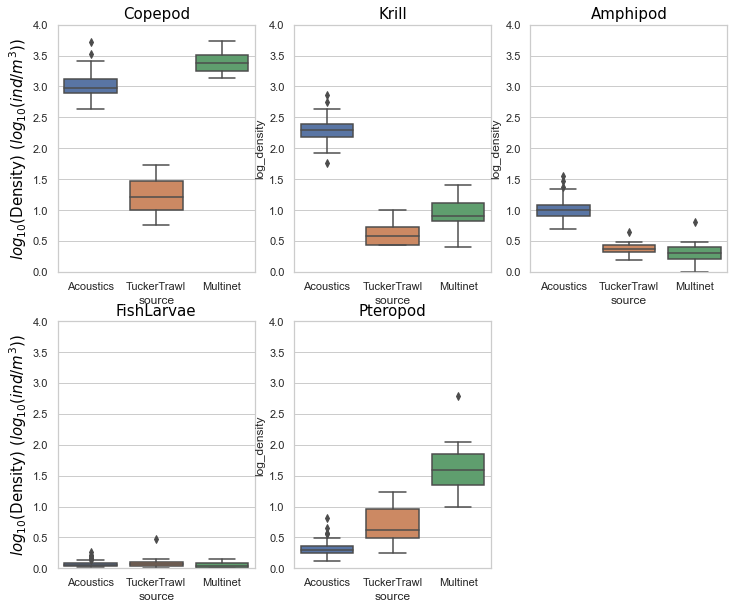

In [30]:
fig = plt.figure(figsize=(12,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.boxplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylim([0,4])
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density) ($log_{10}(ind/m^3)$)', axis_font);

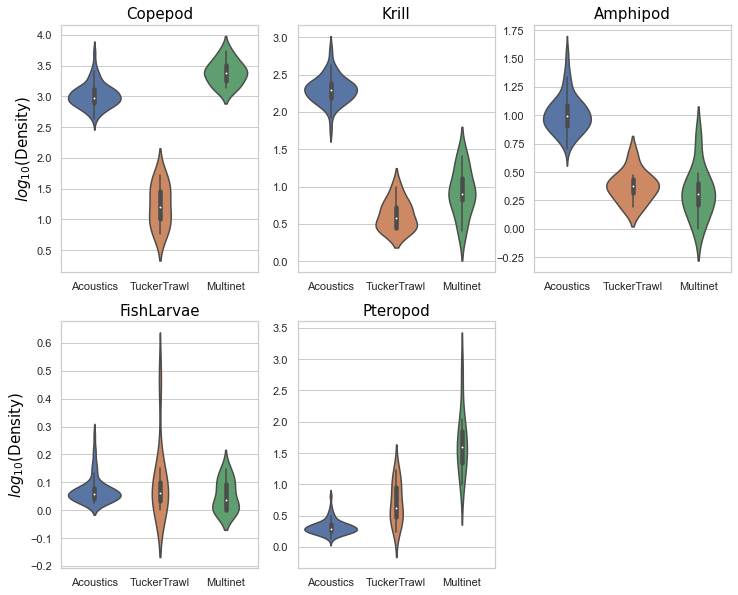

In [31]:
fig = plt.figure(figsize=(12,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.violinplot(data = data[data.species==specs[ind_spec]], x='source', y='log_density')
    ax.set_title(specs[ind_spec], title_font)
    ax.set_ylabel('')
    ax.set_xlabel('')
    if ind_spec==0:
        ax.set_ylabel('$log_{10}$(Density)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('$log_{10}$(Density)', axis_font);

Negative densities... Won't use violin plots here

# Set up per species data

In [32]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'Acoustic'}, 
                            'ignore_index=True')

In [33]:
#Dataframe with all species
for stn_ind in range(7,17):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

In [34]:
data_spec

,lat,lon,datetime,Copepod,Krill,Amphipod,FishLarvae,Pteropod,source
0,70.826248,18.004681,2018-06-21 11:01:13,2501.912846,369.703090,20.572089,0.419796,2.534384,Acoustic
1,70.825203,18.006540,2018-06-21 11:31:11,2005.647450,431.263205,13.876174,0.140124,1.941982,Acoustic
2,70.832222,18.017429,2018-06-21 08:01:08,2577.048793,112.658151,27.983221,0.855916,2.674058,Acoustic
3,70.832222,18.017429,2018-06-21 08:37:04,833.378624,159.677634,8.918156,0.456259,0.907874,Acoustic
4,70.832222,18.017429,2018-06-21 09:01:10,1331.601107,256.481790,7.782412,0.084089,1.304369,Acoustic
...,...,...,...,...,...,...,...,...,...
82,70.091000,18.169000,2018-06-24 02:14:00,2667.742857,7.552381,0.692857,0.000000,38.719048,Multinet
83,70.525000,18.166000,2018-06-24 10:57:00,5.316073,1.725998,2.002157,0.103560,1.518878,TuckerTrawl
84,70.525000,18.166000,2018-06-24 10:57:00,1348.308571,7.158357,1.210071,0.000000,81.275643,Multinet
85,70.500000,16.936000,2018-06-25 05:35:00,11.598706,4.453074,0.586839,0.172600,3.866235,TuckerTrawl


In [35]:
data

,lat,lon,datetime,density,species,source,log_density
0,70.826248,18.004681,2018-06-21 11:01:13,2501.912846,Copepod,Acoustics,3.398446
1,70.825203,18.006540,2018-06-21 11:31:11,2005.647450,Copepod,Acoustics,3.302471
2,70.832222,18.017429,2018-06-21 08:01:08,2577.048793,Copepod,Acoustics,3.411291
3,70.832222,18.017429,2018-06-21 08:37:04,833.378624,Copepod,Acoustics,2.921363
4,70.832222,18.017429,2018-06-21 09:01:10,1331.601107,Copepod,Acoustics,3.124700
...,...,...,...,...,...,...,...
430,70.500000,16.936000,2018-06-25 05:35:00,0.280000,Amphipod,Multinet,0.107210
431,70.500000,16.936000,2018-06-25 05:35:00,3.866235,Pteropod,TuckerTrawl,0.687193
432,70.500000,16.936000,2018-06-25 05:35:00,8.742857,Pteropod,Multinet,0.988686
433,70.500000,16.936000,2018-06-25 05:35:00,0.172600,FishLarvae,TuckerTrawl,0.069150


In [36]:
# Send to R
data.to_feather('.\SSL_density.feather')
data_spec.to_feather('.\SSL_density_spec.feather')

# Compare abundance maps

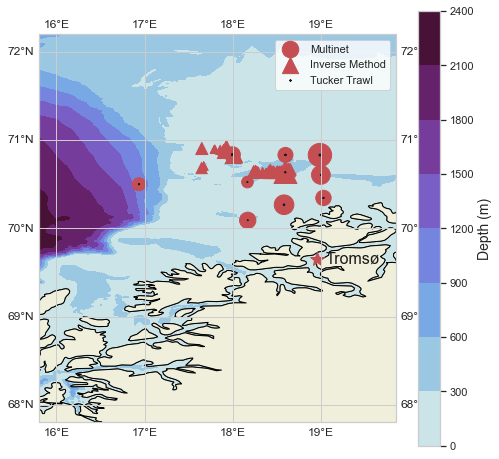

In [37]:
fname_topo = "C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/NordNorgeTopo_tromsoflaket.xlsx"

fig = plt.figure(figsize=(8,8))
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
data_MT = data[data.source=='Multinet']
plt.scatter(data_MT.lon,data_MT.lat,data_MT.density/10,'r', marker='o', label='Multinet')
data_imm = data[data.source=='Acoustics']
plt.scatter(data_imm.lon,data_imm.lat,data_imm.density/10, 'r', marker='^', label='Inverse Method')
data_TT = data[data.source=='TuckerTrawl']
plt.scatter(data_TT.lon,data_TT.lat,data_TT.density/10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

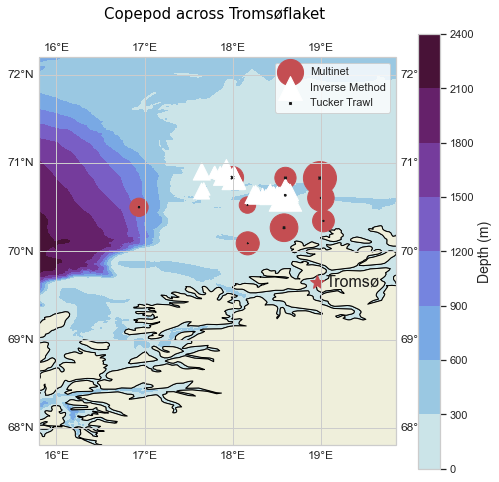

In [38]:
spec = 'Copepod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))

ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.title('%s across Tromsøflaket \n' %spec, title_font)
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density/5,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density/5, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density/5, 'k', marker='x', label='Tucker Trawl')
plt.legend()

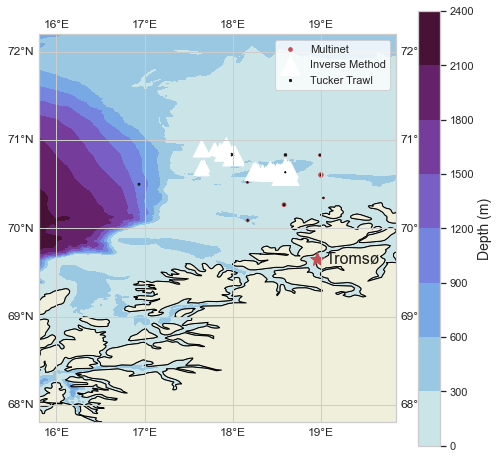

In [39]:
spec = 'Krill'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

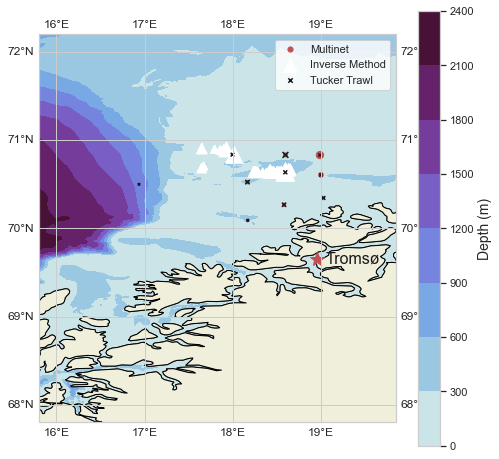

In [40]:
spec = 'Amphipod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*10,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*10, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

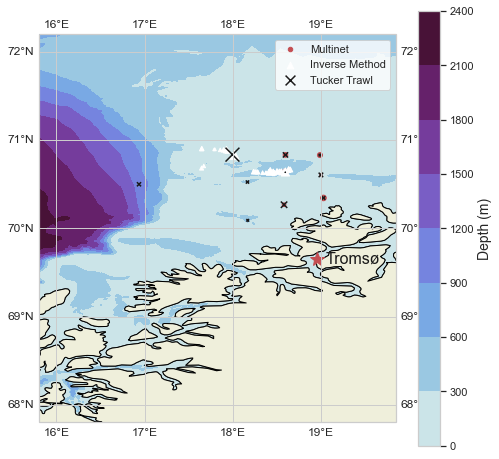

In [41]:
spec = 'FishLarvae'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*100,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*100, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*100, 'k', marker='x', label='Tucker Trawl')
plt.legend()

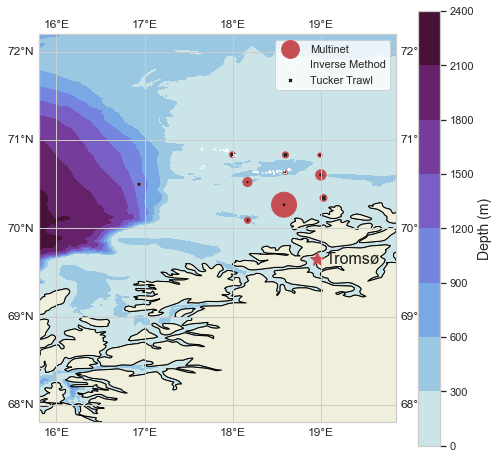

In [42]:
spec = 'Pteropod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

# Plot relative abundance comparison

In [43]:
data_imm.groupby('species').std()

,lat,lon,density,log_density
species,,,,
Amphipod,0.109481,0.323075,5.334725,0.165541
Copepod,0.109481,0.323075,733.953389,0.197535
FishLarvae,0.109481,0.323075,0.146660,0.047460
Krill,0.109481,0.323075,107.001484,0.183323
Pteropod,0.109481,0.323075,0.758369,0.114531


In [44]:
mean_rel_abundance_imm = data_imm.groupby('species').mean()/sum(data_imm.groupby('species').mean()['density'])
mean_rel_abundance_MT = data_MT.groupby('species').mean()/sum(data_MT.groupby('species').mean()['density'])
mean_rel_abundance_TT = data_TT.groupby('species').mean()/sum(data_TT.groupby('species').mean()['density'])
std_rel_abundance_imm = data_imm.groupby('species')['density'].std()/sum(data_imm.groupby('species').mean()['density'])
std_rel_abundance_MT = data_MT.groupby('species')['density'].std()/sum(data_MT.groupby('species').mean()['density'])
std_rel_abundance_TT = data_TT.groupby('species')['density'].std()/sum(data_TT.groupby('species').mean()['density'])

In [45]:
std_rel_abundance_imm

species
Amphipod      0.003777
Copepod       0.519672
FishLarvae    0.000104
Krill         0.075762
Pteropod      0.000537
Name: density, dtype: float64

Text(0, 0.5, 'Relative abundance')

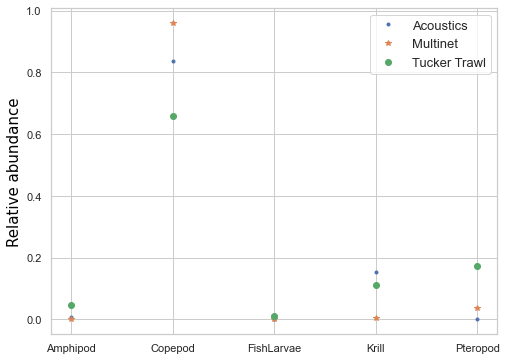

In [46]:
plt.figure(figsize=(8,6))
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_imm['density'], '.', label='Acoustics')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_MT['density'], '*', label='Multinet')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_TT['density'], 'o',label='Tucker Trawl')
plt.legend(fontsize=13)
#plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

In [47]:
sum(mean_rel_abundance_TT['density'])

1.0

Text(0, 0.5, 'Relative abundance')

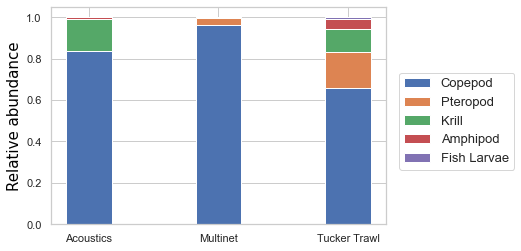

In [48]:
labels = ['Acoustics', 'Multinet','Tucker Trawl']
copepod = np.array([mean_rel_abundance_imm['density'][1], mean_rel_abundance_MT['density'][1], mean_rel_abundance_TT['density'][1]])
pteropod = np.array([mean_rel_abundance_imm['density'][4], mean_rel_abundance_MT['density'][4], mean_rel_abundance_TT['density'][4]])
krill = np.array([mean_rel_abundance_imm['density'][3], mean_rel_abundance_MT['density'][3], mean_rel_abundance_TT['density'][3]])
amphipod = np.array([mean_rel_abundance_imm['density'][0], mean_rel_abundance_MT['density'][0], mean_rel_abundance_TT['density'][0]])
fishlarvae = np.array([mean_rel_abundance_imm['density'][2], mean_rel_abundance_MT['density'][2], mean_rel_abundance_TT['density'][2]])
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, copepod, width, label='Copepod')
ax.bar(labels, pteropod, width, bottom=copepod, label='Pteropod')
ax.bar(labels, krill, width, bottom=copepod+pteropod, label='Krill')
ax.bar(labels, amphipod, width, bottom=copepod+pteropod+krill, label='Amphipod')
ax.bar(labels, fishlarvae, width, bottom=copepod+pteropod+krill+amphipod, label='Fish Larvae')

plt.legend(loc=(1.04, 0.25), fontsize=13)
#plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

Text(0, 0.5, 'Relative abundance')

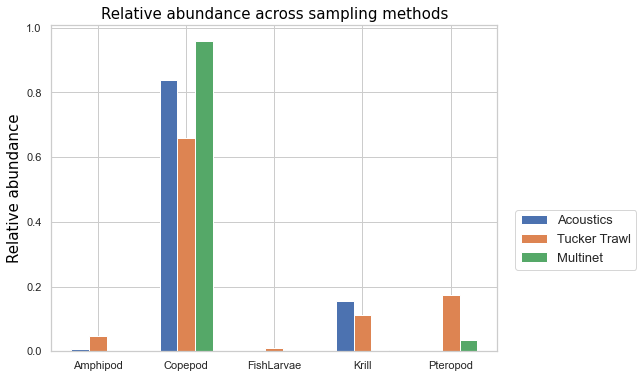

In [49]:
width=0.2
ind = np.arange(5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.bar(ind, mean_rel_abundance_imm['density'], width, label='Acoustics')
ax.bar(ind+width, mean_rel_abundance_TT['density'], width, label='Tucker Trawl')
ax.bar(ind+width+width, mean_rel_abundance_MT['density'], width, label='Multinet')

ax.set_xticks(ind + (2*width) / 2)
ax.set_xticklabels( mean_rel_abundance_imm.index )
plt.legend(loc=(1.04, 0.25), fontsize=13)
plt.title('Relative abundance across sampling methods', title_font);
plt.ylabel('Relative abundance', axis_font)

In [50]:
ind

array([0, 1, 2, 3, 4])

In [51]:
mean_rel_abundance_imm

,lat,lon,density,log_density
species,,,,
Amphipod,0.050075,0.012925,0.007174,0.000716
Copepod,0.050075,0.012925,0.836866,0.002139
FishLarvae,0.050075,0.012925,0.000132,0.000051
Krill,0.050075,0.012925,0.154994,0.001630
Pteropod,0.050075,0.012925,0.000833,0.000227


In [52]:
data_imm.groupby('species').mean()['density']

species
Amphipod        10.132669
Copepod       1181.939820
FishLarvae       0.186731
Krill          218.904809
Pteropod         1.176370
Name: density, dtype: float64

In [53]:
data_MT.groupby('species').mean()['density']

species
Amphipod         1.387000
Copepod       2700.016920
FishLarvae       0.136190
Krill            9.511349
Pteropod       101.288931
Name: density, dtype: float64

In [54]:
np.mean(data_imm[data_imm['species']=='Krill']['density'])


218.90480930016295

In [55]:
data[data.species=='Krill'].groupby('source').mean()['density']

source
Acoustics      218.904809
Multinet         9.511349
TuckerTrawl      3.569364
Name: density, dtype: float64

In [56]:
mean_rel_abundance_imm

,lat,lon,density,log_density
species,,,,
Amphipod,0.050075,0.012925,0.007174,0.000716
Copepod,0.050075,0.012925,0.836866,0.002139
FishLarvae,0.050075,0.012925,0.000132,0.000051
Krill,0.050075,0.012925,0.154994,0.001630
Pteropod,0.050075,0.012925,0.000833,0.000227


In [57]:
mean_rel_abundance_TT

,lat,lon,density,log_density
species,,,,
Amphipod,2.202192,0.574544,0.046443,0.011744
Copepod,2.202192,0.574544,0.659151,0.038387
FishLarvae,2.202192,0.574544,0.010574,0.003226
Krill,2.202192,0.574544,0.111421,0.019252
Pteropod,2.202192,0.574544,0.172411,0.022032


In [58]:
mean_rel_abundance_MT

,lat,lon,density,log_density
species,,,,
Amphipod,0.025085,0.006545,0.000493,0.000114
Copepod,0.025085,0.006545,0.960060,0.001206
FishLarvae,0.025085,0.006545,0.000048,0.000019
Krill,0.025085,0.006545,0.003382,0.000329
Pteropod,0.025085,0.006545,0.036016,0.000594
